In [7]:
!pip install datasets

In [8]:
from datasets import load_dataset

In [9]:
dataset = load_dataset('joelniklaus/brazilian_court_decisions')

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 3234
    })
    validation: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 404
    })
    test: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 405
    })
})

In [10]:
dataset['train'][0]

{'process_number': '0800304-08.2018.8.02.0000',
 'orgao_julgador': 'Tribunal Pleno',
 'publish_date': '12/03/2019',
 'judge_relator': 'Des. João Luiz Azevedo Lessa',
 'ementa_text': 'DIREITO PENAL E PROCESSUAL PENAL. REVISÃO CRIMINAL. ART. 621 DO CÓDIGO DE PROCESSO PENAL. REQUERENTE CONDENADO EM JÚRI POPULAR PELA PRÁTICA DOS CRIMES DE HOMICÍDIO DUPLAMENTE QUALIFICADO E HOMICÍDIO QUALIFICADO TENTADO. PLEITO DE REFAZIMENTO DA DOSIMETRIA DA PENA IMPOSTA AO REQUERENTE. ADMISSIBILIDADE NA VIA REVISIONAL. PRECEDENTES. ALEGAÇÃO DE ERRO NO PROCESSO DE DOSIMETRIA DA PENA. COMPORTAMENTO DA VÍTIMA. CIRCUNSTÂNCIA JUDICIAL NEUTRA QUE NÃO PODE SER CONSIDERADA DE FORMA DESFAVORÁVEL AO SENTENCIANDO SEGUNDO PRECEDENTES DO SUPERIOR TRIBUNAL DE JUSTIÇA E NOVO ENTENDIMENTO DA CÂMARA CRIMINAL DESTE TRIBUNAL DE JUSTIÇA. AFASTAMENTO. CULPABILIDADE. AUSÊNCIA DE EXPOSIÇÃO DE MOTIVOS PARA O INCREMENTO DA PENA-BASE. AFASTADO O DESVALOR. VALORAÇÃO ATRIBUÍDA ÀS CIRCUNSTÂNCIAS DO CRIME MANTIDA. FUNDAMENTAÇÃO IDÔNEA

In [11]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels = dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')


Train size: 3234 -- 3234
Test size: 405 -- 405


In [12]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [14]:
!python -m spacy download pt_core_news_sm

2023-11-29 14:59:47.940571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 14:59:47.940655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 14:59:47.940749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 14:59:47.959635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 14:59:49.805937: W tensorflow/compiler/

In [15]:
import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

In [16]:
train_texts = preprocess_texts(train_texts)

Preprocessing: 100%|██████████| 3234/3234 [01:10<00:00, 46.08it/s]


In [17]:
test_texts = preprocess_texts(test_texts)

Preprocessing: 100%|██████████| 405/405 [00:08<00:00, 47.25it/s]


In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#vectorizer_option = 'binary'
#vectorizer_option = 'count'
vectorizer_option = 'tf_idf'

vectorizer = None

if vectorizer_option == 'binary':
  vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'count':
  ## INCLUIR O VETORIZADOR DE CONTAGEM SIMPLES
  vectorizer = CountVectorizer(binary=False, max_features=None, ngram_range=(1, 1))
  pass
elif vectorizer_option == 'tf_idf':
  ## INCLUIR O VETORIZADOR USANDO TF-IDF
  vectorizer = TfidfVectorizer(max_features=None, ngram_range=(1, 1))
  pass

print(f'Vectorizer Option: {vectorizer_option}')

Vectorizer Option: tf_idf


In [35]:
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f'\nExample Raw Text: {train_texts[0]}')
print(f'\nExample Vectorized Text: {X_train[0]}')


Example Raw Text: direito penal processual penal revisão criminal artigo 621 código processo penal requerente condenado júri popular prática crimes homicídio duplamente qualificado homicídio qualificado tentado pleito refazimento dosimetria pena imposta requerente admissibilidade via revisional precedentes alegação erro processo dosimetria pena comportamento vítima circunstância judicial neutra considerada desfavorável sentenciando precedentes superior tribunal justiça entendimento câmara criminal tribunal justiça afastamento culpabilidade ausência exposição motivos incremento pena-base afastado desvalor valoração atribuída circunstâncias crime mantida fundamentação idônea pena-base reduzida compensação agravante motivação torpe atenuante confissão espontânea pena privativa liberdade redimensionada crime tentado aplicada fração redutora máxima ante distância atos praticados requerente consumação crime pena redimensionada

Example Vectorized Text: [0. 0. 0. ... 0. 0. 0.]


In [36]:
print(f'Vocabulary: {len(vectorizer.vocabulary_)}')

Vocabulary: 12447


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=100),
    'Multinomial NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
     #INCLUIR MAIS 7 NOVOS ALGORITMOS.
    'SVC'  : SVC(),
    'GNB'  : GaussianNB(),
    'SGD'  : SGDClassifier(),
    'DTC'  : DecisionTreeClassifier(),
    'RFC'  : RandomForestClassifier(),
    'QDA'  : QuadraticDiscriminantAnalysis(),
    'LGBM' : MLPClassifier()
}


Classifier: Logistic Regression
{'0': {'precision': 0.8439024390243902, 'recall': 0.7393162393162394, 'f1-score': 0.7881548974943052, 'support': 234}, '1': {'precision': 0.5603448275862069, 'recall': 0.6989247311827957, 'f1-score': 0.6220095693779903, 'support': 93}, '2': {'precision': 0.5833333333333334, 'recall': 0.6282051282051282, 'f1-score': 0.6049382716049383, 'support': 78}, 'accuracy': 0.7086419753086419, 'macro avg': {'precision': 0.6625268666479768, 'recall': 0.6888153662347211, 'f1-score': 0.6717009128257446, 'support': 405}, 'weighted avg': {'precision': 0.7286055301166038, 'recall': 0.7086419753086419, 'f1-score': 0.7147168423481622, 'support': 405}}


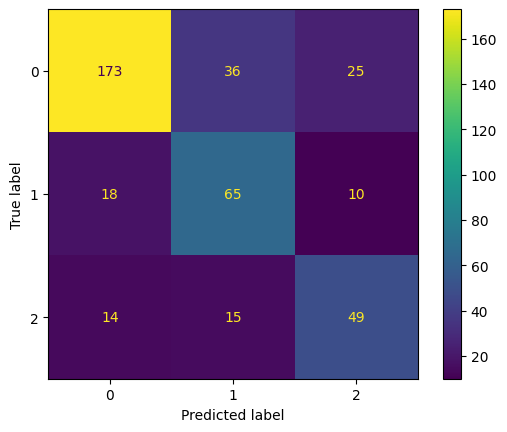


Classifier: Multinomial NB
{'0': {'precision': 0.6047745358090185, 'recall': 0.9743589743589743, 'f1-score': 0.746317512274959, 'support': 234}, '1': {'precision': 0.75, 'recall': 0.22580645161290322, 'f1-score': 0.3471074380165289, 'support': 93}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 78}, 'accuracy': 0.6148148148148148, 'macro avg': {'precision': 0.45159151193633945, 'recall': 0.4000551419906258, 'f1-score': 0.36447498343049595, 'support': 405}, 'weighted avg': {'precision': 0.521647509578544, 'recall': 0.6148148148148148, 'f1-score': 0.5109118261922904, 'support': 405}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


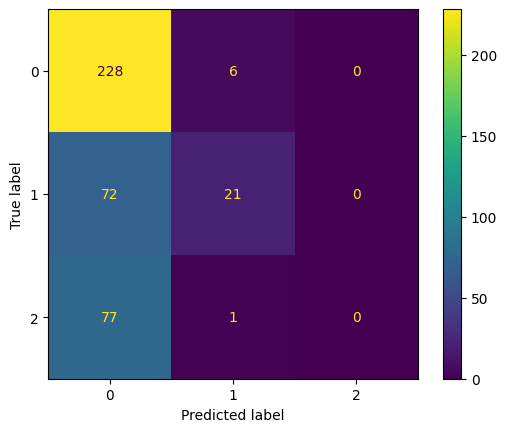


Classifier: KNN
{'0': {'precision': 0.7060931899641577, 'recall': 0.8418803418803419, 'f1-score': 0.7680311890838206, 'support': 234}, '1': {'precision': 0.5657894736842105, 'recall': 0.46236559139784944, 'f1-score': 0.5088757396449705, 'support': 93}, '2': {'precision': 0.58, 'recall': 0.3717948717948718, 'f1-score': 0.453125, 'support': 78}, 'accuracy': 0.6641975308641975, 'macro avg': {'precision': 0.6172942212161227, 'recall': 0.5586802683576877, 'f1-score': 0.5766773095762637, 'support': 405}, 'weighted avg': {'precision': 0.6495906851956654, 'recall': 0.6641975308641975, 'f1-score': 0.647872819833571, 'support': 405}}


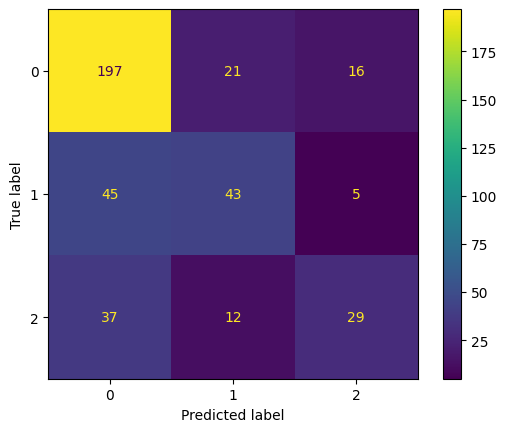


Classifier: SVC
{'0': {'precision': 0.683076923076923, 'recall': 0.9487179487179487, 'f1-score': 0.7942754919499107, 'support': 234}, '1': {'precision': 0.7068965517241379, 'recall': 0.44086021505376344, 'f1-score': 0.543046357615894, 'support': 93}, '2': {'precision': 0.9090909090909091, 'recall': 0.2564102564102564, 'f1-score': 0.3999999999999999, 'support': 78}, 'accuracy': 0.6987654320987654, 'macro avg': {'precision': 0.7663547946306567, 'recall': 0.5486628067273228, 'f1-score': 0.5791072831886015, 'support': 405}, 'weighted avg': {'precision': 0.7320752351097177, 'recall': 0.6987654320987654, 'f1-score': 0.6606512996902647, 'support': 405}}


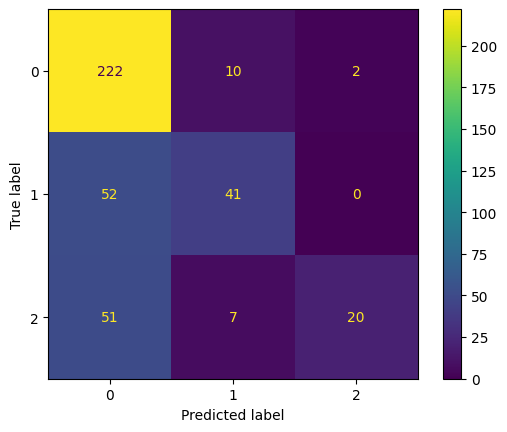


Classifier: GNB
{'0': {'precision': 0.6826086956521739, 'recall': 0.6709401709401709, 'f1-score': 0.6767241379310345, 'support': 234}, '1': {'precision': 0.37777777777777777, 'recall': 0.3655913978494624, 'f1-score': 0.3715846994535519, 'support': 93}, '2': {'precision': 0.4, 'recall': 0.4358974358974359, 'f1-score': 0.4171779141104295, 'support': 78}, 'accuracy': 0.5555555555555556, 'macro avg': {'precision': 0.48679549114331716, 'recall': 0.49080966822902306, 'f1-score': 0.48849558383167196, 'support': 405}, 'weighted avg': {'precision': 0.5581821434961531, 'recall': 0.5555555555555556, 'f1-score': 0.5566684015448293, 'support': 405}}


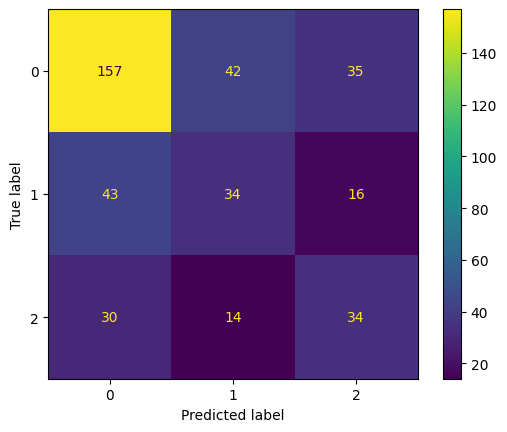


Classifier: SGD
{'0': {'precision': 0.789272030651341, 'recall': 0.8803418803418803, 'f1-score': 0.8323232323232324, 'support': 234}, '1': {'precision': 0.6413043478260869, 'recall': 0.6344086021505376, 'f1-score': 0.6378378378378379, 'support': 93}, '2': {'precision': 0.7115384615384616, 'recall': 0.47435897435897434, 'f1-score': 0.5692307692307692, 'support': 78}, 'accuracy': 0.745679012345679, 'macro avg': {'precision': 0.7140382800052966, 'recall': 0.6630364856171308, 'f1-score': 0.6797972797972799, 'support': 405}, 'weighted avg': {'precision': 0.7403233568400984, 'recall': 0.745679012345679, 'f1-score': 0.7369939636606303, 'support': 405}}


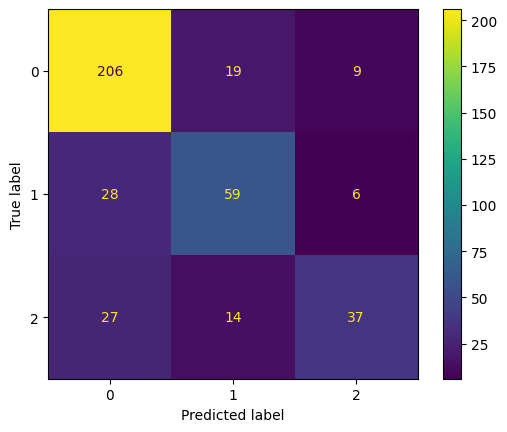


Classifier: DTC
{'0': {'precision': 0.7740585774058577, 'recall': 0.7905982905982906, 'f1-score': 0.7822410147991542, 'support': 234}, '1': {'precision': 0.5454545454545454, 'recall': 0.5806451612903226, 'f1-score': 0.5625, 'support': 93}, '2': {'precision': 0.582089552238806, 'recall': 0.5, 'f1-score': 0.5379310344827586, 'support': 78}, 'accuracy': 0.6864197530864198, 'macro avg': {'precision': 0.633867558366403, 'recall': 0.6237478172962044, 'f1-score': 0.6275573497606376, 'support': 405}, 'weighted avg': {'precision': 0.6845925059626427, 'recall': 0.6864197530864198, 'f1-score': 0.6847296744510056, 'support': 405}}


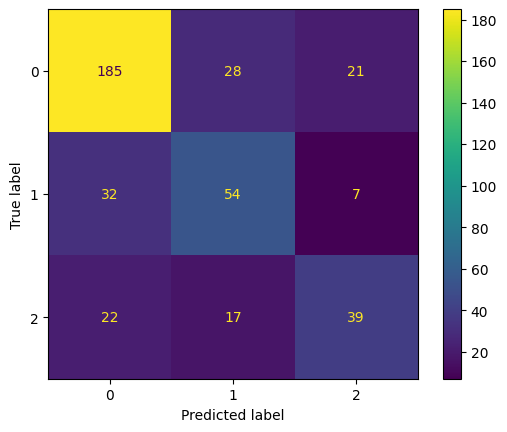


Classifier: RFC
{'0': {'precision': 0.7003154574132492, 'recall': 0.9487179487179487, 'f1-score': 0.8058076225045373, 'support': 234}, '1': {'precision': 0.7547169811320755, 'recall': 0.43010752688172044, 'f1-score': 0.5479452054794521, 'support': 93}, '2': {'precision': 0.8, 'recall': 0.358974358974359, 'f1-score': 0.49557522123893805, 'support': 78}, 'accuracy': 0.7160493827160493, 'macro avg': {'precision': 0.7516774795151081, 'recall': 0.5792666115246761, 'f1-score': 0.6164426830743092, 'support': 405}, 'weighted avg': {'precision': 0.73200616365428, 'recall': 0.7160493827160493, 'f1-score': 0.6868463087216985, 'support': 405}}


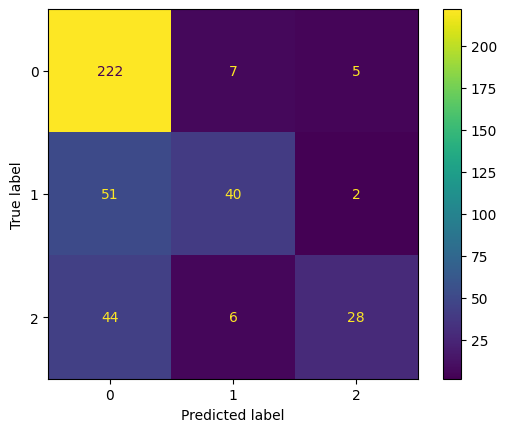


Classifier: QDA


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'0': {'precision': 0.9166666666666666, 'recall': 0.14102564102564102, 'f1-score': 0.2444444444444444, 'support': 234}, '1': {'precision': 0.2616033755274262, 'recall': 0.6666666666666666, 'f1-score': 0.37575757575757573, 'support': 93}, '2': {'precision': 0.22727272727272727, 'recall': 0.38461538461538464, 'f1-score': 0.2857142857142857, 'support': 78}, 'accuracy': 0.30864197530864196, 'macro avg': {'precision': 0.46851425648894, 'recall': 0.3974358974358974, 'f1-score': 0.30197210197210195, 'support': 405}, 'weighted avg': {'precision': 0.6334725596328972, 'recall': 0.30864197530864196, 'f1-score': 0.28254609587942914, 'support': 405}}


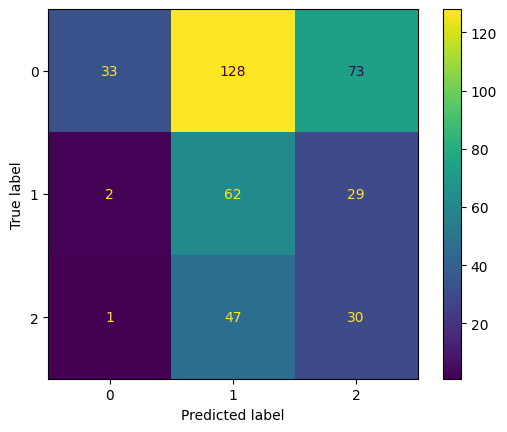


Classifier: LGBM
{'0': {'precision': 0.80078125, 'recall': 0.8760683760683761, 'f1-score': 0.836734693877551, 'support': 234}, '1': {'precision': 0.6703296703296703, 'recall': 0.6559139784946236, 'f1-score': 0.6630434782608695, 'support': 93}, '2': {'precision': 0.6551724137931034, 'recall': 0.48717948717948717, 'f1-score': 0.5588235294117647, 'support': 78}, 'accuracy': 0.7506172839506173, 'macro avg': {'precision': 0.7087611113742579, 'recall': 0.6730539472474956, 'f1-score': 0.6862005671833952, 'support': 405}, 'weighted avg': {'precision': 0.7427825188062256, 'recall': 0.7506172839506173, 'f1-score': 0.7433264126906801, 'support': 405}}


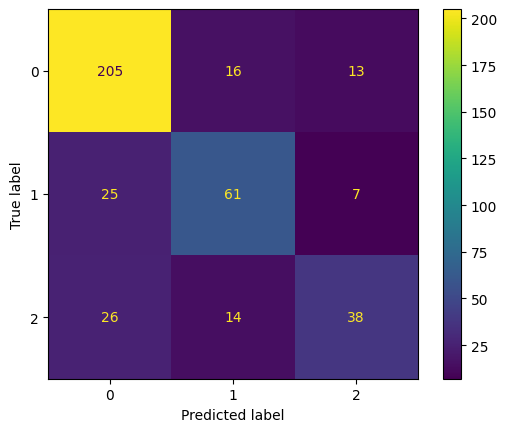

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

from sklearn.metrics import classification_report, ConfusionMatrixDisplay


for classifier_name, classifier in classifiers.items():

  print(f'\nClassifier: {classifier_name}')

  classifier.fit(X_train, train_labels)

  y_pred = classifier.predict(X_test)

  report = classification_report(test_labels, y_pred, output_dict=True)

  print(report)

  ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

  plt.show()

  df = pd.DataFrame(report).transpose()

  #df.to_csv('resultados_binary_'+classifier_name+'_anderson_hericca.csv', index = False)
  #df.to_csv('resultados_count_'+classifier_name+'_anderson_hericca.csv', index = False)
  df.to_csv('resultados_tf_idf_'+classifier_name+'_anderson_hericca.csv', index = False)



  """
    Gerar os resultados do classification_report para cada um dos 10 algoritmos.
    Montar uma planilha com os resultados das medidas (Acurácia e weighted avg
    da Precisão, Cobertura e F1-Score).
    Destacar em negrito o melhor algoritmo para cada medida de avaliação.
  """